# Project 2.0 ADD-ON: Monte Carlo Matchup Simulation

*Experimental notebook distinct from the required coursework.* We extend the binary matchup model with Monte Carlo simulations to estimate win probabilities and expected score margins for hypothetical pairings.


## Advantages and Disadvantages of this Add-on
- **Advantages:** Produces probabilistic forecasts, aligns with sports analytics practices, and supports scenario analysis for arbitrary matchups.
- **Disadvantages:** Relies on distributional assumptions (Gaussian noise), adds computational cost, and introduces additional models that must be explained.


## How to run
1. Install requirements (scikit-learn).
2. Launch Jupyter from the project root.
3. Execute cells to retrain models and run Monte Carlo simulations.

In [1]:
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

PROJECT_ROOT = Path.cwd()
if PROJECT_ROOT.name == 'addons':
    PROJECT_ROOT = PROJECT_ROOT.parent.parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

FIG_DIR = PROJECT_ROOT / 'figures'
TABLE_DIR = PROJECT_ROOT / 'tables'
FIG_DIR.mkdir(exist_ok=True)
TABLE_DIR.mkdir(exist_ok=True)

sns.set_theme(style='whitegrid')
from sklearn.linear_model import LinearRegression

from src.core import data_loading as core_dl
from src.core import feature_engineering as core_fe
from src.core import models_game_outcome as core_mgo
from src.addons import monte_carlo_matchups as add_mc


## Prepare matchup data and train models

In [2]:
team_season = core_dl.load_team_season()
teams = core_dl.load_teams()
team_features = core_fe.build_team_season_features(team_season, teams)
matchups = core_fe.build_pairwise_matchups(team_features)

train_df, test_df = core_mgo.season_train_test_split(matchups, train_ratio=0.7)
X_train, y_train, feature_cols = core_mgo.prepare_features(train_df)
X_test = test_df[feature_cols]
y_test = test_df['label']

models = core_mgo.train_models(train_df, feature_cols=feature_cols)
rf_model = models['random_forest']
print('Random forest ready for probabilistic simulation.')

reg_features = [col for col in feature_cols if col != 'diff_margin']
reg_model = LinearRegression()
reg_model.fit(train_df[reg_features], train_df['diff_margin'])
print('Fitted linear regression to approximate point differential using remaining features.')


Random forest ready for probabilistic simulation.
Fitted linear regression to approximate point differential using remaining features.


## Run simulations for sample matchups

In [3]:
example_rows = test_df.sample(n=3, random_state=42)
results = []
for _, row in example_rows.iterrows():
    x_cls = row[feature_cols].to_frame().T
    cls_summary = add_mc.simulate_matchup_from_classifier(rf_model, x_cls.values, n_sim=5000)

    x_reg = row[reg_features].to_frame().T
    reg_summary = add_mc.simulate_matchup_from_regressor(reg_model, x_reg.values, n_sim=5000)

    results.append({
        'season': row['year'],
        'team_a': row['team_name_a'],
        'team_b': row['team_name_b'],
        **{f'classifier_{k}': v for k, v in cls_summary.items()},
        **{f'regressor_{k}': v for k, v in reg_summary.items()},
    })

results_df = pd.DataFrame(results)
monte_table_path = TABLE_DIR / 'monte_carlo_example_matchups.csv'
results_df.to_csv(monte_table_path, index=False)
print(f'Saved Monte Carlo summary table to {monte_table_path}')
results_df


C:\Users\nkany\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\nkany\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\nkany\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\nkany\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\nkany\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\v

Saved Monte Carlo summary table to C:\Users\nkany\OneDrive\Desktop\Desktop\Machine Learning\Project\tables\monte_carlo_example_matchups.csv


C:\Users\nkany\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


,season,team_a,team_b,classifier_base_proba,classifier_simulated_win_prob,classifier_sim_std,classifier_n_sim,regressor_base_point_diff,regressor_expected_margin,regressor_simulated_win_prob,regressor_n_sim
0,1991,Charlotte Hornets,Utah Jazz,0.0,0.019759,0.029513,5000,-10.292683,-10.031904,0.1600,5000
1,2001,Orlando Magic,Chicago Bulls,1.0,0.980970,0.028409,5000,10.109756,10.347046,0.8484,5000
2,2004,Portland Trailblazers,Dallas Mavericks,0.0,0.019689,0.028957,5000,-9.743902,-9.627251,0.1728,5000


## Visualise simulated margin distribution

C:\Users\nkany\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Saved margin histogram to C:\Users\nkany\OneDrive\Desktop\Desktop\Machine Learning\Project\figures\monte_carlo_margin_hist.png


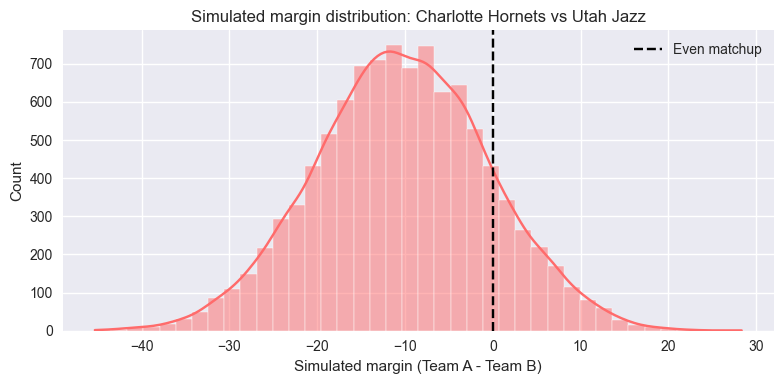

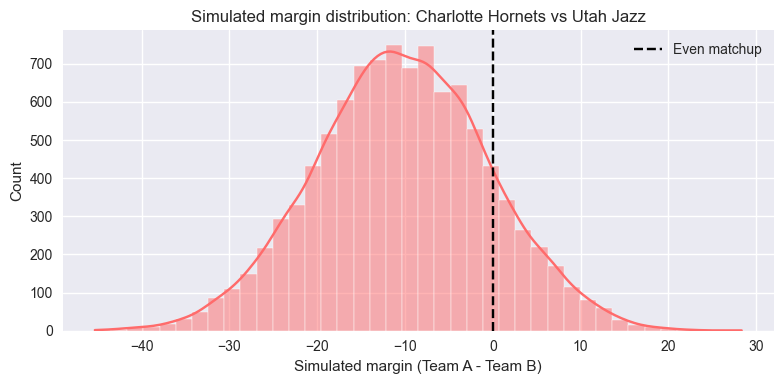

In [4]:
first_row = example_rows.iloc[0]
x_reg = first_row[reg_features].to_frame().T
reg_summary = add_mc.simulate_matchup_from_regressor(reg_model, x_reg.values, n_sim=10000, return_samples=True)
draws = reg_summary.pop('samples')

fig, ax = plt.subplots(figsize=(8, 4))
sns.histplot(draws, bins=40, kde=True, ax=ax, color='#ff6b6b')
ax.axvline(0, color='black', linestyle='--', label='Even matchup')
ax.set_title(f"Simulated margin distribution: {first_row['team_name_a']} vs {first_row['team_name_b']}")
ax.set_xlabel('Simulated margin (Team A - Team B)')
ax.legend()
fig.tight_layout()
margin_fig_path = FIG_DIR / 'monte_carlo_margin_hist.png'
fig.savefig(margin_fig_path, dpi=300)
print(f'Saved margin histogram to {margin_fig_path}')
fig


## Summary: Should this Add-on be Included in the Final Report?
Monte Carlo simulations add storytelling value and mimic professional analytics, but they introduce new assumptions and require clear communication about noise models. Include this section as an exploratory appendix unless the rubric rewards probabilistic forecasting.
